In [24]:
from glob import glob
import os

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib import cm
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from rasterio.plot import plotting_extent
from shapely.geometry import box
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
import scipy.io
import pandas as pd
import h5py
# optional - turn off warnings
import warnings
warnings.filterwarnings('ignore')

os.chdir('/users/marianne/documents/pe_snow_fires/')

In [96]:
homedir = 'c:/users/marianne/documents/pe_snow_fires'
northwest = ['upper sacramento','feather','yuba','american','cosumnes','mokelumne','stanislaus']
southwest = ['tuolumne','merced','san joaquin','kings','kaweah','tule','kern']
southeast = ['owens','mono','walker']
northeast = ['truckee','tahoe','carson']
all_watersheds = sorted(northwest+northeast+southeast+southwest)
np.save('all_watersheds.npy',all_watersheds)

os.chdir(homedir)

In [97]:
all_watersheds=np.load('all_watersheds.npy')
all_watersheds

array(['american', 'carson', 'cosumnes', 'feather', 'kaweah', 'kern',
       'kings', 'merced', 'mokelumne', 'mono', 'owens', 'san joaquin',
       'stanislaus', 'tahoe', 'truckee', 'tule', 'tuolumne',
       'upper sacramento', 'walker', 'yuba'], dtype='<U16')

In [16]:
tmp = h5py.File('watershed_masks/watershed_masks/american_watershed_mask.mat','r')

In [77]:
## bring in sierra nevada range
filepath = '/users/marianne/documents/data/watershed_masks/'
files = os.listdir(filepath)
tmp_list=[]
outlines_list=[]
for f in files:
    try:
        mask = h5py.File(filepath + f)
        name = f.split('_watershed')[0]
        outline = mask[name+'_watershed_outline_coords']
        points = gpd.points_from_xy(outline['x'][0],outline['y'][0],z=None)
        outlines_list.append([outline['x'][0],outline['y'][0]])
        poly = Polygon(points)
        # use the feature loop in case the polygon is a multipolygon
        features = [i for i in range(1)]
        tmp_list.append({'geometry': poly,'name':name})
    except:
        continue

gdf = gpd.GeoDataFrame(tmp_list,crs=4326)
gdf.to_file('watersheds.gdf')


In [103]:
mask = h5py.File(filepath + 'cosumnes_watershed_mask.mat')


OSError: Unable to open file (file signature not found)

In [100]:
gdf

,geometry,name
0,"POLYGON ((-121.17542 38.73486, -121.17542 38.7...",american
1,"POLYGON ((-119.99208 38.70986, -119.99208 38.7...",carson
2,"POLYGON ((-121.58375 39.91403, -121.58375 39.9...",feather
3,"POLYGON ((-119.00847 36.40181, -119.00847 36.4...",kaweah
4,"POLYGON ((-118.64208 35.97431, -118.64208 35.9...",kern
5,"POLYGON ((-119.42097 36.93931, -119.42097 36.9...",kings
6,"POLYGON ((-120.33375 37.71403, -120.33375 37.7...",merced
7,"POLYGON ((-120.87542 38.29319, -120.87542 38.2...",mokelumne
8,"POLYGON ((-119.32083 37.97056, -119.32083 37.9...",mono
9,"POLYGON ((-119.10417 37.72083, -119.10417 37.7...",owens


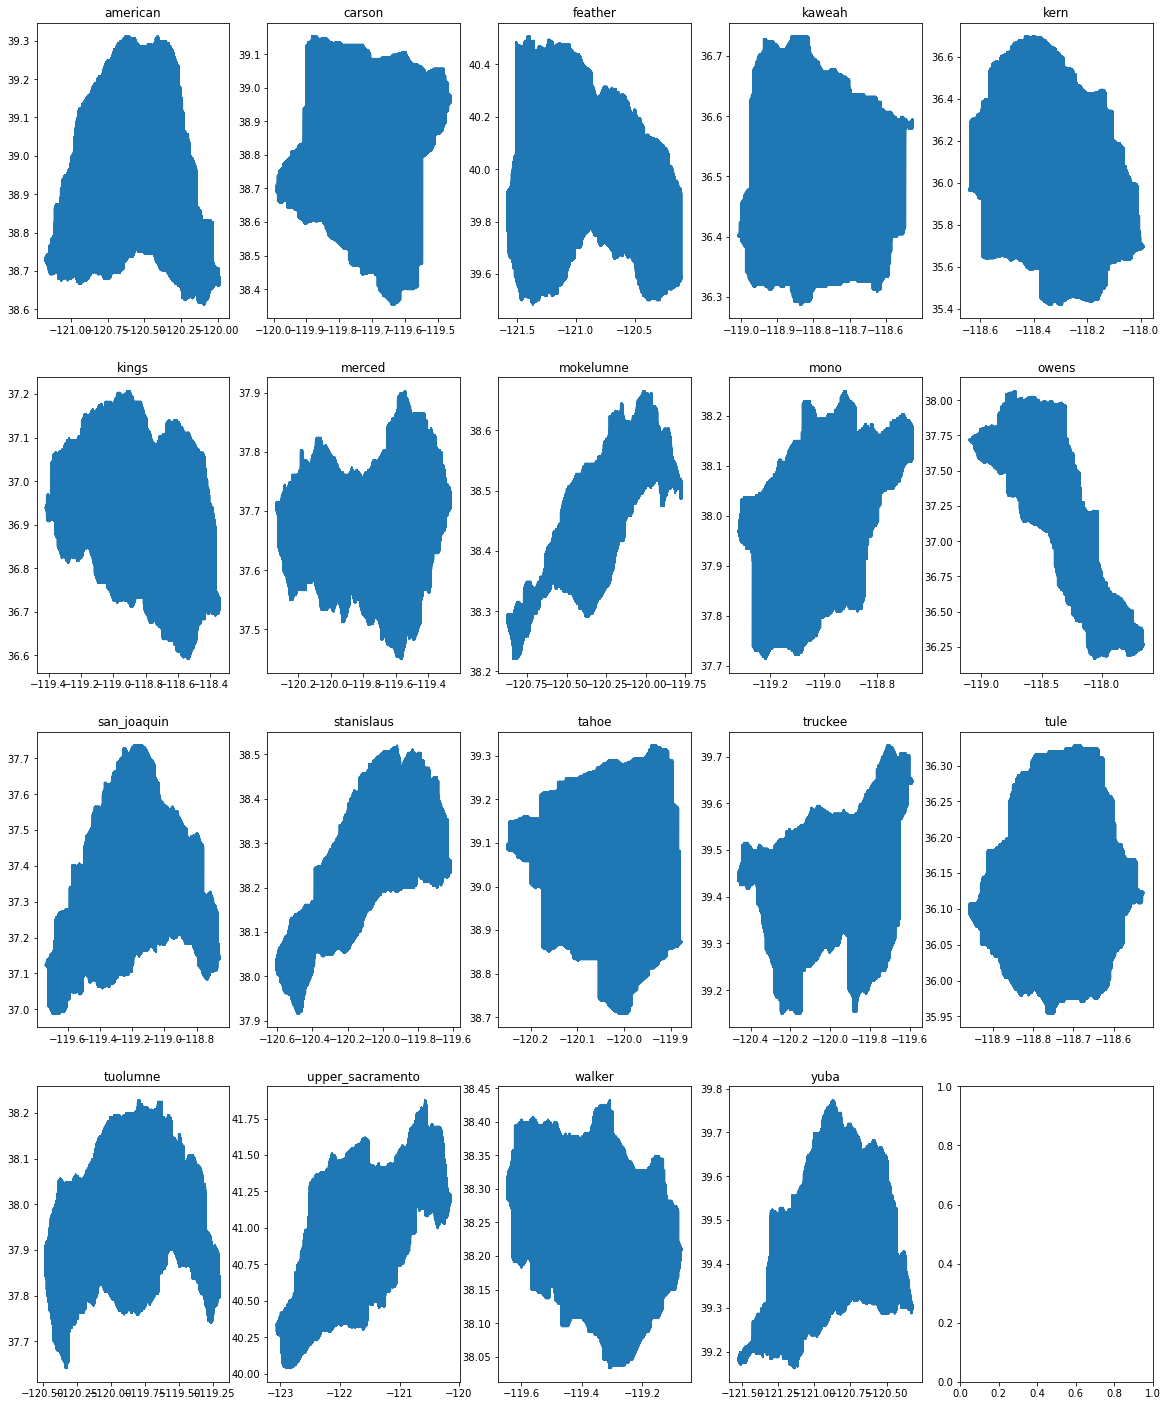

In [105]:
f,ax=plt.subplots(4,5,figsize=(20,25))
axs=ax.flatten()
for i in range(19):
    axs[i].plot(outlines_list[i][0],outlines_list[i][1])
    axs[i].set_title(gdf['name'][i])

In [75]:
watersheds = gpd.read_file('watersheds.gdf')

<AxesSubplot:>

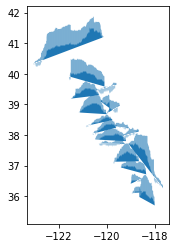

In [76]:
watersheds.plot()